In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


import os


# CCL
import pyccl as ccl
from pyccl.halos.massdef import MassDef

import sys 
import math 
from emantis.halo_mass_function import HMFEmulator




## Cosmological Parameters

In [3]:
#P18 Cosmology from emantis paper
Omega_m = 0.3071
Omega_b = 0.048446 
Omega_c =  Omega_m - Omega_b
Omega_k = 0.0 
H0      = 68.03
h       = H0 / 100.0
Tcmb0   = 2.7255 
A_s     = 2.1e-9 
sigma8  = 0.8224 
n_s     = 0.96641 
Neff    = 3.046
w0      = -1.0 
wa      = 0.0 
Tinker_lin_interp = True
area = 439.78986


## Emulator initialization and Defining its Cosmo parameters

In [4]:
hmf_emu = HMFEmulator(model = "wCDM", mass_def="200c")

In [5]:
cosmo_parameters = {
'Omega_b':Omega_b,
'Omega_m':Omega_m,
'sigma8':sigma8,
'n_s':n_s,
'w': -1,
'h':h,
}

## CCL Cosmology

In [6]:
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
                          h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k,
                          w0=w0, wa=wa, T_CMB=Tcmb0, m_nu=[0.00, 0.0, 0.0], 
                          transfer_function='eisenstein_hu', matter_power_spectrum='linear')

In [7]:
## Redshift array to be used

In [8]:
# Array of redshifts
z_arr = np.linspace(0.0,1.5,4)

## Ccl mass functions

In [9]:

mass_def_val = '200c'
ccl_hmf_T08 = ccl.halos.MassFuncTinker08(mass_def=mass_def_val)
ccl_hmf_B16 = ccl.halos.MassFuncBocquet16(mass_def=mass_def_val)
ccl_hmf_D16 = ccl.halos.MassFuncDespali16(mass_def=mass_def_val)
ccl_hmfs = [ccl_hmf_T08, ccl_hmf_B16, ccl_hmf_D16 ]
ccl_hmfs_name = [('T08', 'red'), ('B16', 'blue'), ('D16', 'green')]

## Plotting mass functions for redshift 0

Be aware that CCL mass functions give the resunts in log10 of mass and emulator is in natural log (dn/dlog10M versus dn/dlogM). That is why I multiply the results for the emulator by ln(10). Also the emulator gives the answer in 1/ m*h^3

<Figure size 640x480 with 0 Axes>

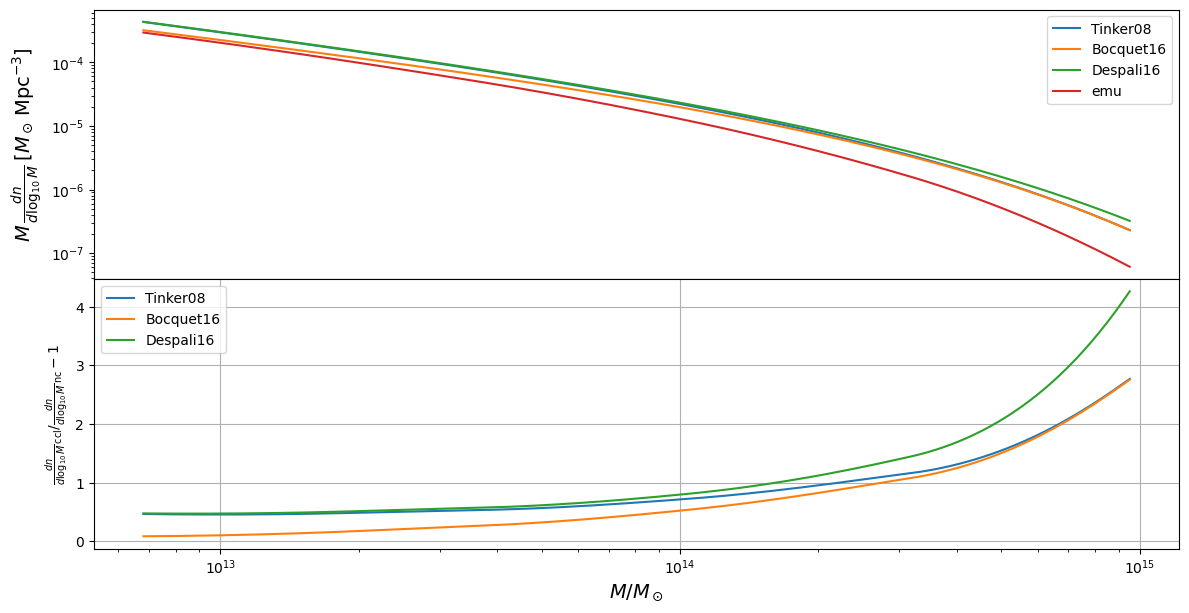

In [11]:
%matplotlib inline
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))
m = hmf_emu.range('mass_halo', aexp=1.0)
m_arr = np.geomspace(m[0], m[1], 128) 
for ccl_mf_obj in ccl_hmfs:
    ccl_mf = ccl_mf_obj(cosmo_ccl, m_arr, 1.0) 
    axs[0].plot(m_arr*h, ccl_mf, label = ccl_mf_obj.name)
    hmf_vals = np.array(hmf_emu.predict_hmf(m_arr, cosmo_parameters, 1.0)) * np.log(10.0) * h**3
    emu_nm = np.array(hmf_vals)

    axs[1].plot (m_arr*h, np.abs ( ccl_mf/ emu_nm  - 1.0), '-', label = ccl_mf_obj.name)
axs[0].plot(m_arr*h, emu_nm, label = 'emu')    

#Plot settings
axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
#axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
axs[0].legend(loc='best')

axs[1].legend(loc='best')
axs[1].grid()

fig.show()
plt.show ()

## Comparison

### so=200c

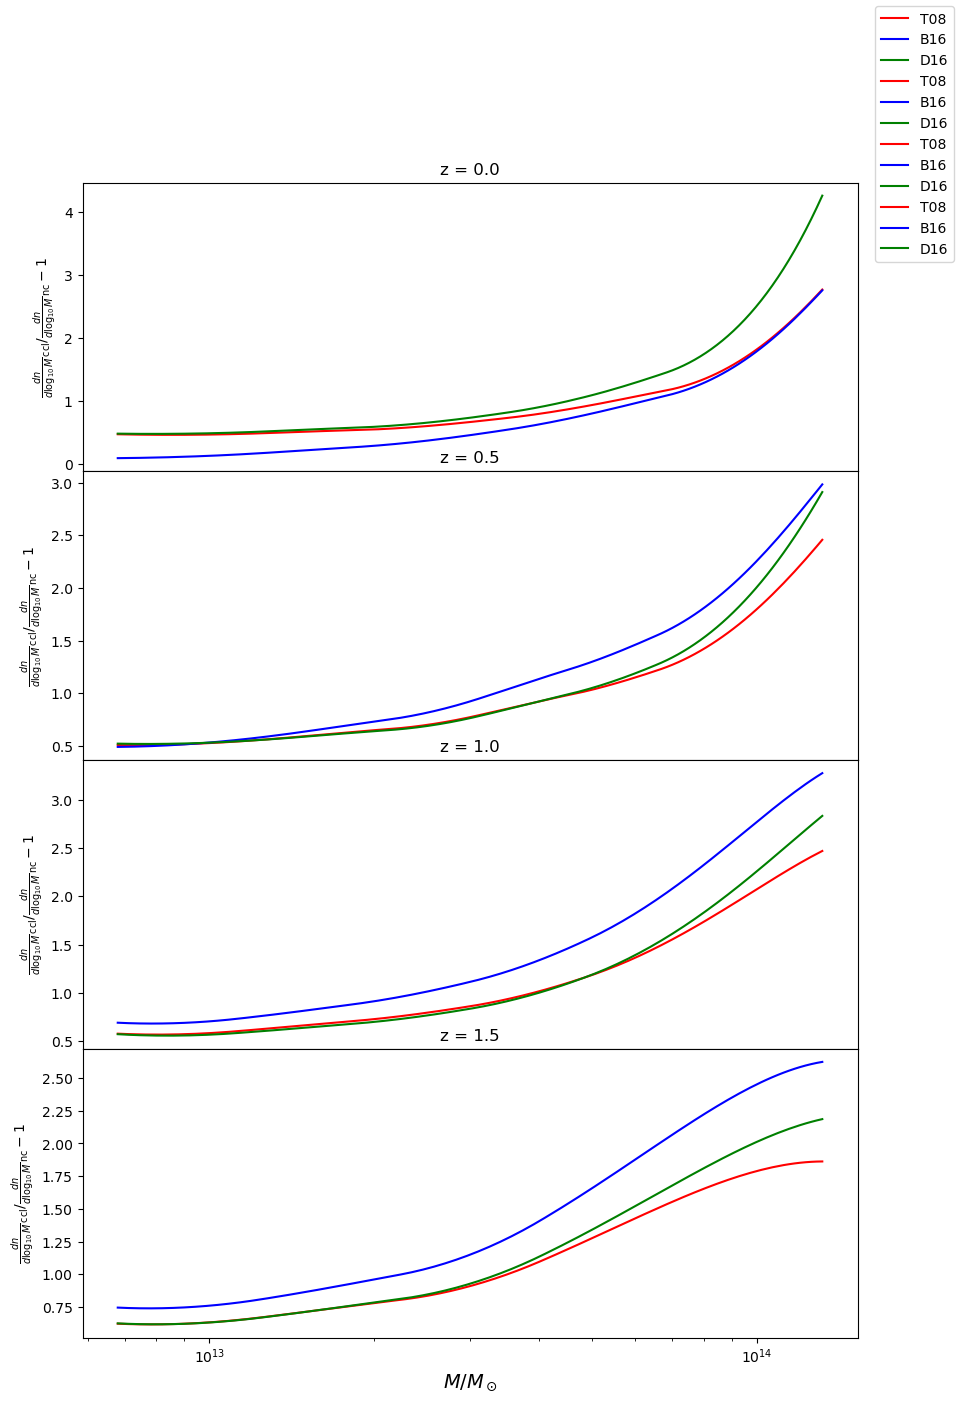

In [32]:
#fig 11 from paper right
%matplotlib inline

scale = 4
fig, axs = plt.subplots( 4, figsize = (10,15))
fig.subplots_adjust(wspace=0, hspace=0)
for i,z in enumerate(z_arr):
    aexp = float(1. / (1. + z))
    m_range = hmf_emu.range("mass_halo", aexp=aexp)
    m_arr = np.geomspace(m_range[0],m_range[1],128)
    hmf_vals = np.array(hmf_emu.predict_hmf(m_arr, cosmo_parameters, aexp)) * math.log(10.0) *  h**3
    for ccl_hmf, name_t in zip(ccl_hmfs, ccl_hmfs_name):
        if name_t[0] == 'W13':
            continue
        name = name_t[0]
        color = name_t[1]
        ccl_vals = ccl_hmf(cosmo_ccl, m_arr, aexp)
        rel_dif = (np.array(ccl_vals)/np.array(hmf_vals)) -1
        axs[i].plot(h*m_arr, rel_dif, label=f'{name}', color=color)
    axs[i].title.set_text(f'z = {z}')
    axs[i].set_xscale ('log')
    axs[i].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}}  / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
    axs[i].set_xlabel(r'$M/M_\odot$', fontsize=14)


fig.legend()
fig.show()

## Now this is for fig 12, where we change the w parameter

In [16]:
cosmo_parameters_w = {
'Omega_b':Omega_b,
'Omega_m':Omega_m,
'sigma8':sigma8,
'n_s':n_s,
'w': -1,
'h':h,
}

cosmo_ccl_w = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
                          h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k,
                          w0=w0, wa=wa, T_CMB=Tcmb0, m_nu=[0.00, 0.0, 0.0], 
                          transfer_function='eisenstein_hu', matter_power_spectrum='linear')

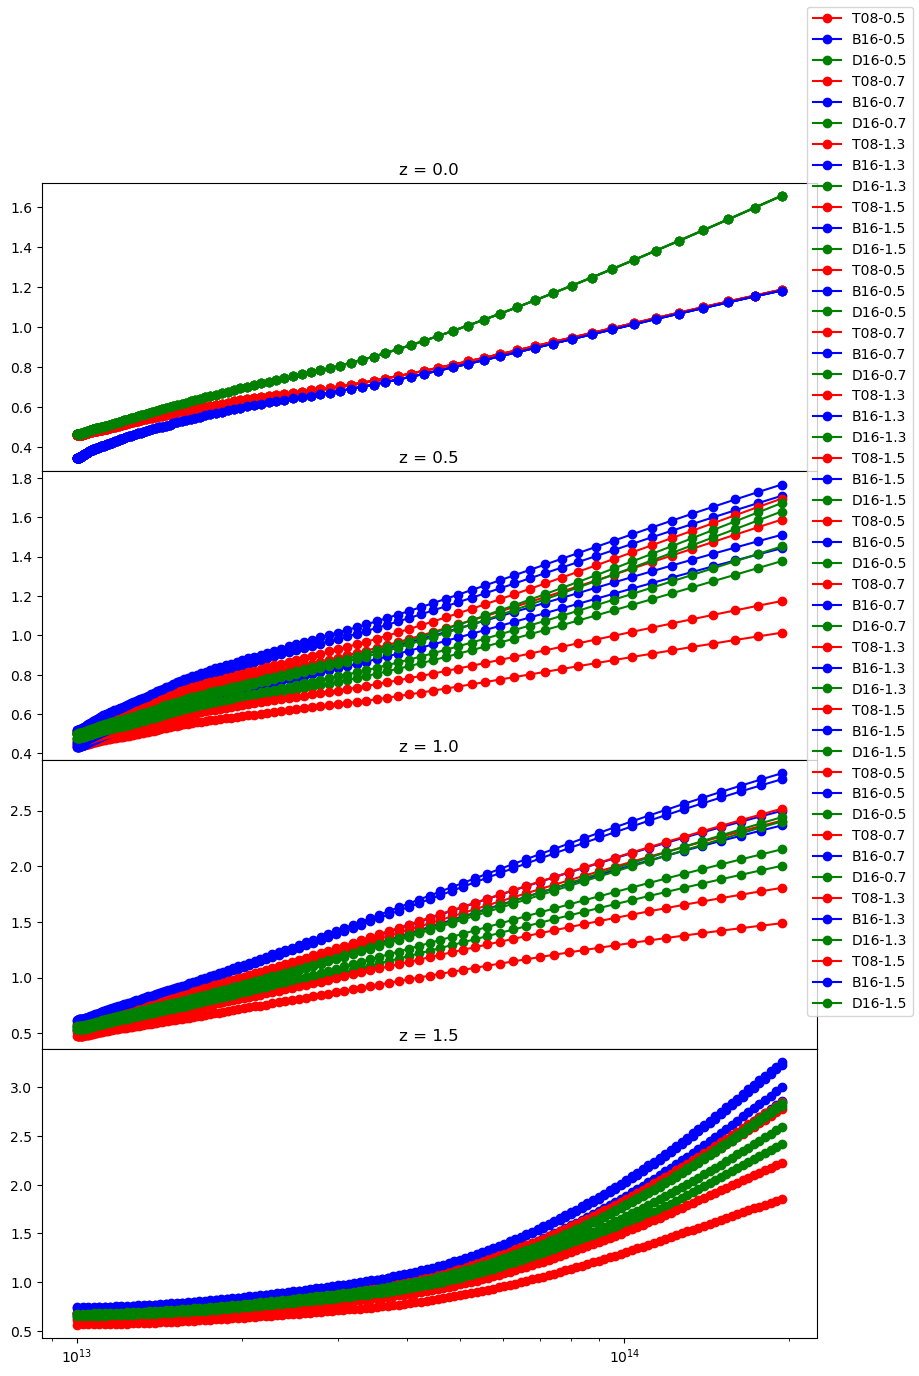

In [17]:
#fig 12 from paper right
%matplotlib inline
w_list = [-0.5, -0.7, -1.3,-1.5]
scale = 4
fig, axs = plt.subplots( 4, figsize = (10,15))
fig.subplots_adjust(wspace=0, hspace=0)
for w in w_list:
    for i,z in enumerate(z_arr):
        aexp = float(1. / (1. + z))
        m_range = hmf_emu.range("mass_halo", aexp=aexp)
        m_arr = np.geomspace(m_range[0],m_range[1],128)
        hmf_vals_l = hmf_emu.predict_hmf(m_arr, cosmo_parameters_w, aexp) * np.log(10)
        cosmo_ccl_w.cosmo.params.w0 = w
        for ccl_hmf, name_t in zip(ccl_hmfs, ccl_hmfs_name):
            name = name_t[0]
            color = name_t[1]
            ccl_vals = ccl_hmf(cosmo_ccl_w, m_arr, aexp)
            rel = np.array(ccl_vals)/np.array(hmf_vals_l)
            axs[i].plot(m_arr, rel, marker='o', label=f'{name}{w}', color=color)
        axs[i].title.set_text(f'z = {z}')
plt.xscale('log')
fig.legend()
fig.show()

### FoF mass

In [13]:
## fig 11

In [14]:

hmf_emu_fof = HMFEmulator(model = "wCDM", mass_def="b0.2")
ccl_hmf_W13 = ccl.halos.MassFuncWatson13(mass_def='fof')
ccl_hmfs_2 = [  ccl_hmf_W13]
ccl_hmfs_name_2 = [ 'W13']

e-MANTIS:hmf:b0.2:aexp_1.0 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_1.0 ...training completed.
e-MANTIS:hmf:b0.2:aexp_0.625 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.625 ...training completed.
e-MANTIS:hmf:b0.2:aexp_0.6667 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.6667 ...training completed.
e-MANTIS:hmf:b0.2:aexp_0.5 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.5 ...training completed.
e-MANTIS:hmf:b0.2:aexp_0.4 Training the emulator...
e-MANTIS:hmf:b0.2:aexp_0.4 ...training completed.


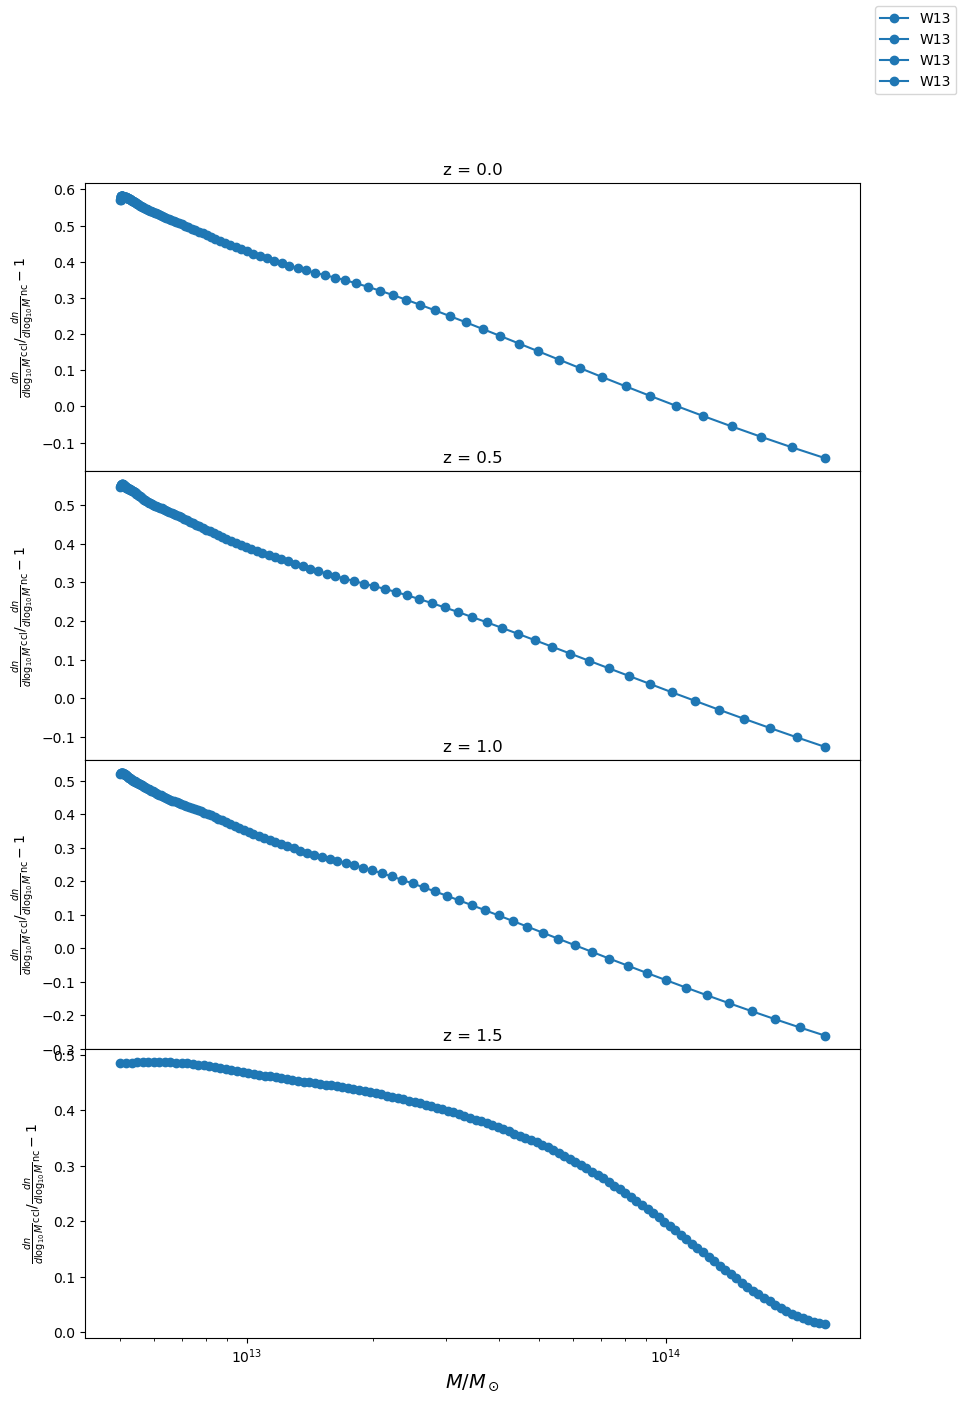

In [15]:
#fig 12 from paper
%matplotlib inline
scale = 4
fig, axs = plt.subplots( 4, figsize = (10,15))
fig.subplots_adjust(wspace=0, hspace=0)
for i,z in enumerate(z_arr):
    aexp = float(1. / (1. + z))
    m_range = hmf_emu_fof.range("mass_halo", aexp=aexp)
    m_arr = np.geomspace(m_range[0],m_range[1],128)
    hmf_vals = hmf_emu_fof.predict_hmf(m_arr, cosmo_parameters, aexp) * math.log(10)
    for ccl_hmf, name in zip(ccl_hmfs_2, ccl_hmfs_name_2):
        ccl_vals = ccl_hmf(cosmo_ccl, m_arr, aexp)
        rel_dif = (np.array(hmf_vals) - np.array(ccl_vals))/np.array(hmf_vals)
        axs[i].plot(m_arr, rel_dif, marker='o', label=f'{name}')
    axs[i].title.set_text(f'z = {z}')
    axs[i].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}}  / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
    axs[i].set_xlabel(r'$M/M_\odot$', fontsize=14)
plt.xscale('log')
fig.legend()
fig.show()